In [1]:
import tweepy
from tweepy import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import datetime as dt
import csv
import pandas as pd

In [ ]:
#biden tweets

consumerkey = #
consumersecret = #
accesskey = #
accesssecret = #


class StdOutListener(StreamListener):
    def on_status(self, status):
        if (status.lang == "en") & (status.user.followers_count >= 500): #filter by English language, followers to mitigate spam
            if hasattr(status,'extended_tweet'):
                text = status.extended_tweet['full_text']
            else:
                text = status.text
                
            csvw.writerow([status.id, status.user.screen_name,
                       status.created_at,
                       status.user.followers_count,
                       text])
            return True
    
    def on_error(self, status_code): #prevent exceeding Twitter's rate limit
        if status_code == 420:
            return False
        
if __name__ == "__main__":
    l = StdOutListener()
    auth = OAuthHandler(consumerkey, consumersecret)
    auth.set_access_token(accesskey, accesssecret)
    stream = Stream(auth, l, tweet_mode = 'extended')
    
 #create csv to store tweets
    csvw = csv.writer(open("bidentweets.csv", "a"))
    csvw.writerow(["id", "username", "date", "followers", "text"]) #csv headings
    tags = ["joe+biden", "biden", "vp+biden", "biden+town+hall"]
    stream.filter(track=tags)

In [ ]:
#trump tweets

consumerkey = #
consumersecret = #
accesskey = #
accesssecret = #


class StdOutListener(StreamListener):
    def on_status(self, status):
        if (status.lang == "en") & (status.user.followers_count >= 500): #filter by English language, followers to mitigate spam
            if hasattr(status,'extended_tweet'):
                text = status.extended_tweet['full_text']
            else:
                text = status.text
                
            csvw.writerow([status.id, status.user.screen_name,
                       status.created_at,
                       status.user.followers_count,
                       text])
            return True
    
    def on_error(self, status_code): #prevent exceeding Twitter's rate limit
        if status_code == 420:
            return False
        
if __name__ == "__main__":
    l = StdOutListener()
    auth = OAuthHandler(consumerkey, consumersecret)
    auth.set_access_token(accesskey, accesssecret)
    stream = Stream(auth, l, tweet_mode = 'extended')
    
 #create csv to store tweets
    csvw = csv.writer(open("trumptweets.csv", "a"))
    csvw.writerow(["id", "username", "date", "followers", "text"]) #csv headings
    tags = ["donald+trump", "trump", "president+trump", "trump+town+hall"]
    stream.filter(track=tags)

In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib as mpl
from datetime import timezone, datetime
import pytz
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
stop_words = set(stopwords.words('english'))

In [3]:
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding = "latin-1") #load csv into pandas dataframe
    dataset.columns = cols
    return dataset

def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col] #identify columns to drop from dataset
        
    return dataset

In [14]:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweets
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove @
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    lemmatizer = WordNetLemmatizer() #lemmatize words to dictionary form
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    
    return " ".join(lemma_words)

In [15]:
#load training dataset

dataset = load_dataset("training.csv", ["target", "t_id", "created_at", "query", "user", "text"])
n_dataset = remove_unwanted_cols(dataset, ["t_id", "created_at", "query", "user"])
dataset.text = dataset["text"].apply(preprocess_tweet_text)

In [16]:
#load biden tweets

bidentweets = load_dataset("bidentweets.csv", ["id", "username", "date", "followers", "text"])
n_bidentweets = remove_unwanted_cols(bidentweets, ["id", "username", "followers"])
bidentweets.text = bidentweets["text"].apply(preprocess_tweet_text)

In [17]:
#load trump tweets

trumptweets = load_dataset("trumptweets.csv", ["id", "username", "date", "followers", "text"])
n_trumptweets = remove_unwanted_cols(trumptweets, ["id", "username", "followers"])
trumptweets.text = trumptweets["text"].apply(preprocess_tweet_text)

In [18]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [19]:
tf_vector = get_feature_vector(np.array(dataset.iloc[:, 1]).ravel()) #vectorize training data for model
X = tf_vector.transform(np.array(dataset.iloc[:, 1]).ravel())
y = np.array(dataset.iloc[:, 0]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [20]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))
print(classification_report(y_test, y_predict_nb))

0.767609375
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    160465
           4       0.77      0.75      0.76    159535

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [21]:
#vectorize biden and trump tweets

bidenvector = tf_vector.transform(np.array(bidentweets.iloc[:, 1]).ravel())
trumpvector = tf_vector.transform(np.array(trumptweets.iloc[:, 1]).ravel())

In [22]:
#Using Naive Bayes model for prediction

#biden
bidenmodelrun = NB_model.predict(bidenvector)
bidenpredictions = pd.DataFrame({"text": bidentweets.text, "date": bidentweets.date, "prediction": bidenmodelrun})
bidenpredictions["date"] = pd.to_datetime(bidenpredictions.date, format = "%Y-%m-%d %H:%M:%S")
bidenpredictions["date"] = bidenpredictions["date"].dt.tz_localize(timezone.utc)
easterntimezone = pytz.timezone("America/New_York") #convert time from utc to edt
bidenpredictions["date"] = bidenpredictions["date"].dt.tz_convert(easterntimezone) #convert time from utc to edt

#trump
trumpmodelrun = NB_model.predict(trumpvector)
trumppredictions = pd.DataFrame({"text": trumptweets.text, "date": trumptweets.date, "prediction": trumpmodelrun})
trumppredictions["date"] = pd.to_datetime(trumppredictions.date, format = "%Y-%m-%d %H:%M:%S")
trumppredictions["date"] = trumppredictions["date"].dt.tz_localize(timezone.utc)
easterntimezone = pytz.timezone("America/New_York") #convert time from utc to edt
trumppredictions["date"] = trumppredictions["date"].dt.tz_convert(easterntimezone) #convert time from utc to edt

In [75]:
bidenpredictions.shape, trumppredictions.shape

((148711, 4), (144401, 4))

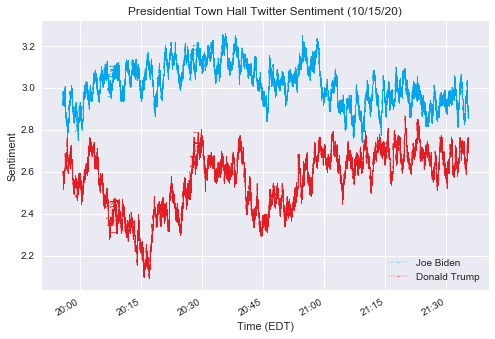

In [73]:
#visualization

import matplotlib.style as style
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
mpl.rcParams["timezone"] = "America/New_York"
style.use("seaborn")

bidenpredictions["rollingaverage"] = bidenpredictions.iloc[:,2].rolling(window = 1000).mean()
trumppredictions["rollingaverage"] = trumppredictions.iloc[:,2].rolling(window = 1000).mean()

plt.plot_date(bidenpredictions["date"], bidenpredictions["rollingaverage"], linestyle = "-", linewidth = 0.2, markersize = 1, color = "#00A6EF", label = "Joe Biden")
plt.plot_date(trumppredictions["date"], trumppredictions["rollingaverage"], linestyle = "-", linewidth = 0.2, markersize = 1, color = "#E81B23", label = "Donald Trump")
plotformat = mdates.DateFormatter("%H:%M")
plt.gcf().axes[0].xaxis.set_major_formatter(plotformat)

plt.gcf().autofmt_xdate()
plt.title("Presidential Town Hall Twitter Sentiment (10/15/20)")
plt.xlabel("Time (EDT)")
plt.ylabel("Sentiment")
plt.legend(loc = "lower right")
plt.savefig("presidentialtownhallsentiment.png")